In [ ]:
# PDF印刷用
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

try:
    from google.colab import files
except:
    pass

pdf_ind = 2
pdf_base = 'pdf-01-'

def create_pdf():
    global pdf_ind, pdf_base
    fn = f'{pdf_base}{pdf_ind:02d}.pdf'
    print(fn)
    plt.rcParams['figure.subplot.bottom'] = 0.15
    plt.rcParams['figure.subplot.left'] = 0.15
    plt.savefig(fn)
    try:
        files.download(fn)
    except:
        pass
    pdf_ind = pdf_ind + 1

### 11.4  学習の単位

### ライブラリ・環境設定

#### ライブラリ導入

In [ ]:
# 必要ライブラリ追加導入
!pip install japanize-matplotlib -qq
!pip install torchviz -qq
!pip install torchinfo -qq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 68.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


#### ライブラリインポート

In [ ]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchinfo import summary
from tqdm.notebook import tqdm

#### 環境設定

In [ ]:
np.set_printoptions(formatter={'float': '{:0.3f}'.format})
pd.options.display.float_format = '{:.3f}'.format
warnings.filterwarnings('ignore')

#### GPU存在チェック

In [ ]:
# GPU存在チェック

# GPUが利用可能かどうかのチェック
device = torch.device("cuda:0" \
if torch.cuda.is_available() else "cpu")

# 利用可能な場合は"cuda:0"が出力される
print(device)

cuda:0


### データ準備

#### データローダー構築

In [ ]:
# データローダー構築
def get_data_loaders(batch_size=100, data_dir="./data"):
    """MNISTの訓練・テストデータをDataLoaderで返す"""
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    train_set = datasets.MNIST(root=data_dir, train=True, download=True, transform=transform)
    test_set  = datasets.MNIST(root=data_dir, train=False, download=True, transform=transform)

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, pin_memory=True)
    test_loader  = DataLoader(test_set,  batch_size=batch_size, shuffle=False, pin_memory=True)

    return train_loader, test_loader

batch_size = 100
train_loader, test_loader = get_data_loaders(batch_size)


100%|██████████| 9.91M/9.91M [00:00<00:00, 20.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 494kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.66MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.93MB/s]


### モデル構築

#### モデル定義

In [ ]:
# モデル定義

class Net(nn.Module):
    """全結合1層のシンプルなNN（MNIST想定: 28*28 -> 100 -> 10）"""
    def __init__(self, n_input=28*28, n_hidden=100, n_output=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_input, n_hidden),
            nn.ReLU(inplace=True),
            nn.Linear(n_hidden, n_output)
        )

    def forward(self, x):
        # (B, 1, 28, 28) -> (B, 784)
        x = torch.flatten(x, 1)
        return self.net(x)

#### 訓練用関数

In [ ]:
# 学習用関数

def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for inputs, labels in loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # 勾配初期化
        optimizer.zero_grad()
        # 予測計算
        outputs = model(inputs)
        # 損失計算
        loss = criterion(outputs, labels)
        # 勾配(微分)計算
        loss.backward()
        # パラメータ更新
        optimizer.step()

        with torch.no_grad():
            preds = outputs.argmax(1)
            running_loss += loss.item() * labels.size(0)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return running_loss / total, correct / total

#### 検証用関数

In [ ]:
# 検証用関数

@torch.no_grad()
def validate(model, loader, criterion):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0

    for inputs, labels in loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        preds = outputs.argmax(1)

        running_loss += loss.item() * labels.size(0)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return running_loss / total, correct / total

#### 学習関数

In [ ]:
def fit(*, net_class=Net, n_hidden=100, num_epochs=20, lr=0.01,
        batch_size=100, optimizer_class=optim.SGD,
        seed=42, data_dir="./data"):
    """
    引数（すべてキーワード専用）:
        net_class       : モデルクラス（例: Net, CustomCNNなど）
        n_hidden        : 隠れ層ノード数（Net使用時のみ）
        num_epochs      : 繰り返し数
        lr              : 学習率
        batch_size      : バッチサイズ
        optimizer_class : 最適化関数クラス (例: optim.SGD, optim.Adam)

    戻り値:
        model, history(np.ndarray: [epoch, train_loss, train_acc, val_loss, val_acc])
    """
    torch.manual_seed(seed)
    np.random.seed(seed)

    # DataLoader作成（バッチサイズ指定）
    train_loader, test_loader = get_data_loaders(batch_size=batch_size,
                                                 data_dir=data_dir)

    # モデル構築（引数対応）
    try:
        model = net_class(n_hidden=n_hidden).to(device)
    except TypeError:
        model = net_class().to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optimizer_class(model.parameters(), lr=lr)

    history = []
    for epoch in tqdm(range(1, num_epochs + 1), desc="Training"):
        tr_loss, tr_acc = train_one_epoch(model, train_loader, criterion,
                                          optimizer)
        va_loss, va_acc = validate(model, test_loader, criterion)

        print(
            f"Epoch [{epoch}/{num_epochs}] "
            f"train_loss: {tr_loss:.5f}, train_acc: {tr_acc:.5f}, "
            f"val_loss: {va_loss:.5f}, val_acc: {va_acc:.5f}"
        )
        history.append([epoch, tr_loss, tr_acc, va_loss, va_acc])

    return model, np.array(history, dtype=float)

#### 学習

In [ ]:
batch_sizes = [500, 200, 100, 50]
histories = []
models = []
for batch_size in batch_sizes:
  model, history = fit(num_epochs=20, lr=0.01, batch_size=batch_size)
  histories.append(history)
  models.append(model)

Training:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/20] train_loss: 1.49819, train_acc: 0.65533, val_loss: 0.86651, val_acc: 0.82480
Epoch [2/20] train_loss: 0.69410, train_acc: 0.84733, val_loss: 0.54686, val_acc: 0.87250
Epoch [3/20] train_loss: 0.50958, train_acc: 0.87402, val_loss: 0.44410, val_acc: 0.88730
Epoch [4/20] train_loss: 0.43610, train_acc: 0.88493, val_loss: 0.39435, val_acc: 0.89610
Epoch [5/20] train_loss: 0.39583, train_acc: 0.89223, val_loss: 0.36392, val_acc: 0.90050
Epoch [6/20] train_loss: 0.36989, train_acc: 0.89723, val_loss: 0.34315, val_acc: 0.90620
Epoch [7/20] train_loss: 0.35131, train_acc: 0.90067, val_loss: 0.32840, val_acc: 0.90870
Epoch [8/20] train_loss: 0.33682, train_acc: 0.90398, val_loss: 0.31694, val_acc: 0.91170
Epoch [9/20] train_loss: 0.32499, train_acc: 0.90748, val_loss: 0.30666, val_acc: 0.91330
Epoch [10/20] train_loss: 0.31494, train_acc: 0.91012, val_loss: 0.29782, val_acc: 0.91530
Epoch [11/20] train_loss: 0.30612, train_acc: 0.91277, val_loss: 0.29013, val_acc: 0.91720
Epoch [1

Training:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/20] train_loss: 0.98426, train_acc: 0.77467, val_loss: 0.48456, val_acc: 0.88210
Epoch [2/20] train_loss: 0.43048, train_acc: 0.88560, val_loss: 0.36501, val_acc: 0.90060
Epoch [3/20] train_loss: 0.35781, train_acc: 0.89913, val_loss: 0.32223, val_acc: 0.90930
Epoch [4/20] train_loss: 0.32400, train_acc: 0.90710, val_loss: 0.29848, val_acc: 0.91420
Epoch [5/20] train_loss: 0.30148, train_acc: 0.91342, val_loss: 0.28062, val_acc: 0.92030
Epoch [6/20] train_loss: 0.28432, train_acc: 0.91827, val_loss: 0.26649, val_acc: 0.92410
Epoch [7/20] train_loss: 0.26988, train_acc: 0.92223, val_loss: 0.25556, val_acc: 0.92840
Epoch [8/20] train_loss: 0.25728, train_acc: 0.92607, val_loss: 0.24558, val_acc: 0.93180
Epoch [9/20] train_loss: 0.24598, train_acc: 0.92968, val_loss: 0.23590, val_acc: 0.93500
Epoch [10/20] train_loss: 0.23565, train_acc: 0.93288, val_loss: 0.22643, val_acc: 0.93730
Epoch [11/20] train_loss: 0.22624, train_acc: 0.93532, val_loss: 0.21773, val_acc: 0.93980
Epoch [1

Training:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/20] train_loss: 0.70944, train_acc: 0.82948, val_loss: 0.36484, val_acc: 0.90030
Epoch [2/20] train_loss: 0.34260, train_acc: 0.90292, val_loss: 0.30016, val_acc: 0.91420
Epoch [3/20] train_loss: 0.29471, train_acc: 0.91510, val_loss: 0.26729, val_acc: 0.92500
Epoch [4/20] train_loss: 0.26505, train_acc: 0.92348, val_loss: 0.24612, val_acc: 0.93000
Epoch [5/20] train_loss: 0.24184, train_acc: 0.93078, val_loss: 0.22569, val_acc: 0.93780
Epoch [6/20] train_loss: 0.22313, train_acc: 0.93635, val_loss: 0.21003, val_acc: 0.94170
Epoch [7/20] train_loss: 0.20713, train_acc: 0.94155, val_loss: 0.19760, val_acc: 0.94460
Epoch [8/20] train_loss: 0.19323, train_acc: 0.94583, val_loss: 0.18607, val_acc: 0.94630
Epoch [9/20] train_loss: 0.18111, train_acc: 0.94885, val_loss: 0.17638, val_acc: 0.95000
Epoch [10/20] train_loss: 0.17037, train_acc: 0.95200, val_loss: 0.16643, val_acc: 0.95260
Epoch [11/20] train_loss: 0.16080, train_acc: 0.95498, val_loss: 0.15776, val_acc: 0.95460
Epoch [1

Training:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/20] train_loss: 0.52950, train_acc: 0.86482, val_loss: 0.29984, val_acc: 0.91590
Epoch [2/20] train_loss: 0.28259, train_acc: 0.91892, val_loss: 0.24807, val_acc: 0.93060
Epoch [3/20] train_loss: 0.23531, train_acc: 0.93235, val_loss: 0.21050, val_acc: 0.94110
Epoch [4/20] train_loss: 0.20201, train_acc: 0.94262, val_loss: 0.18889, val_acc: 0.94510
Epoch [5/20] train_loss: 0.17706, train_acc: 0.95042, val_loss: 0.16542, val_acc: 0.95170
Epoch [6/20] train_loss: 0.15806, train_acc: 0.95545, val_loss: 0.14977, val_acc: 0.95700
Epoch [7/20] train_loss: 0.14240, train_acc: 0.95997, val_loss: 0.13884, val_acc: 0.95930
Epoch [8/20] train_loss: 0.12924, train_acc: 0.96378, val_loss: 0.12844, val_acc: 0.96280
Epoch [9/20] train_loss: 0.11811, train_acc: 0.96740, val_loss: 0.12124, val_acc: 0.96540
Epoch [10/20] train_loss: 0.10877, train_acc: 0.97002, val_loss: 0.11411, val_acc: 0.96650
Epoch [11/20] train_loss: 0.10084, train_acc: 0.97205, val_loss: 0.10674, val_acc: 0.96930
Epoch [1

### 結果確認

#### グラフ描画関数

In [ ]:
# グラフ描画関数

import matplotlib.pyplot as plt

def plot_learning_curves_multi(histories, labels=None, title_suffix=""):
    """
    複数のhistoryを黒と青のみで重ねて描画
    実線: 訓練データ, 破線: テストデータ
    """
    plt.figure(figsize=(10, 4), tight_layout=True)

    # --- 線スタイルの組み合わせ（黒と青のみ）---
    colors = ['b', 'k', 'b', 'k']        # 4本まで対応
    linestyles = ['-', '--', ':', '-.']  # パターンで区別

    # --- 損失曲線 ---
    plt.subplot(1, 2, 1)
    for i, history in enumerate(histories):
        epochs = history[:, 0]
        train_loss = history[:, 1]
        val_loss = history[:, 3]
        color = colors[i % len(colors)]
        ls_val = linestyles[(i + 0) % len(linestyles)]  # テストは異なる線種

        label_val   = f"{labels[i]}(テスト)" if labels else f"model{i+1}(テスト)"

        plt.plot(epochs, val_loss,   color=color, linestyle=ls_val,   label=label_val)

    plt.xlabel('繰り返し回数')
    plt.ylabel('損失')
    plt.title(f'学習曲線（損失）{title_suffix}')
    plt.legend(fontsize=8)
    plt.grid(True)

    # --- 精度曲線 ---
    plt.subplot(1, 2, 2)
    for i, history in enumerate(histories):
        epochs = history[:, 0]
        train_acc = history[:, 2]
        val_acc   = history[:, 4]
        color = colors[i % len(colors)]
        ls_val = linestyles[(i + 0) % len(linestyles)]

        label_val   = f"{labels[i]}(テスト)" if labels else f"model{i+1}(テスト)"

        plt.plot(epochs, val_acc,   color=color, linestyle=ls_val,   label=label_val)

    plt.xlabel('繰り返し回数')
    plt.ylabel('精度')
    plt.xticks(np.arange(0,21,2))
    plt.title(f'学習曲線（精度）{title_suffix}')
    plt.legend(fontsize=8)
    plt.grid(True)
    create_pdf()
    plt.show()


#### グラフ描画

pdf-01-06.pdf


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

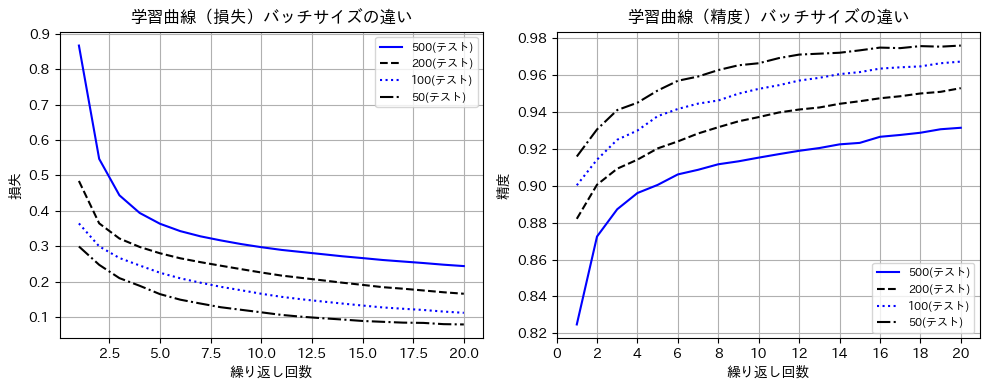

In [ ]:
# グラフ描画
plot_learning_curves_multi(
    histories,
    labels=["500", "200", "100", "50"],
    title_suffix="バッチサイズの違い"
)


### バージョン確認

In [ ]:
!pip install watermark -qq
%load_ext watermark
%watermark --iversions

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
japanize_matplotlib: 1.1.3
torch              : 2.8.0+cu126
torchinfo          : 1.8.0
pandas             : 2.2.2
tqdm               : 4.67.1
numpy              : 2.0.2
torchvision        : 0.23.0+cu126
matplotlib         : 3.10.0

